# EEG Source Reconstruction Pipeline

This notebook outlines a step-by-step procedure to:
1. Load and prepare EEG data from an EEGLAB `.set` file.
2. Compute a forward solution using MNE’s `fsaverage` template.
3. Invert sensor-level data to source space (i.e., estimate cortical current densities).
4. Parcellate those sources into anatomically defined ROIs (Desikan-Killiany atlas).
5. (Optionally) reshape the results back to an epoch-like structure for easier viewing.

Let's get started!

***

In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib qt

# (Optional) Path setup for your project
raw_data_path = '../data/raw/'
source_path = '../data/source_reconstruction/'


## 1. Load EEG Epochs

We load preprocessed EEG data stored in an EEGLAB `.set` file and convert it to an 
MNE `Epochs` object. This gives us a structured representation of the data with
event-based segmentation (epochs).



In [ ]:
path = raw_data_path + 'PPT1/'
input_fname = path + 's_101_Coordination.set'
epochs = mne.io.read_epochs_eeglab(input_fname)
print(epochs)

# Subsample epochs to reduce memory usage (optional)
# epochs = epochs[:5]  # e.g., only keep first 5 epochs


Extracting parameters from /Users/s204684/Work/Special Course 2/Mirror_LEiDA/notebooks/../data/raw/PPT1/s_101_Coordination.set...
Not setting metadata
87 matching events found


/var/folders/v3/57xh39sd4g107fc_xrn2v6xc0000gp/T/ipykernel_45790/760799689.py:3: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(input_fname)
/var/folders/v3/57xh39sd4g107fc_xrn2v6xc0000gp/T/ipykernel_45790/760799689.py:3: RuntimeWarning: Data file name in EEG.data (s_01_Coordination_AverageReref.fdt) is incorrect, the file name must have changed on disk, using the correct file name (s_101_Coordination.fdt).
  epochs = mne.io.read_epochs_eeglab(input_fname)


No baseline correction applied
0 projection items activated
Ready.
<EpochsEEGLAB | 87 events (all good), -1 – 4.996 s (baseline off), ~65.3 MiB, data loaded,
 '154/134/134': 32
 '134/114/154/134': 16
 '114/154/134/134': 24
 '134/154/134': 15>


## 2. Set Montage

We apply the standard 64-channel BioSemi montage to ensure that electrode positions are accurately mapped in 3D space.


In [ ]:
montage = mne.channels.make_standard_montage('biosemi64')
epochs.set_montage(montage)

<EpochsEEGLAB | 5 events (all good), -1 – 4.996 s (baseline off), ~3.8 MiB, data loaded,
 '154/134/134': 2
 '134/114/154/134': 1
 '114/154/134/134': 1
 '134/154/134': 1>

## 3. Compute Forward Solution

A forward solution maps neural sources in the brain to the EEG electrodes. We use
the MNE-supplied `fsaverage` template, which includes:
- A source space (`ico-5`) describing dipole locations on the cortical mesh
- A BEM model describing how currents propagate through the scalp/skull/brain
- A standard head-to-MRI transform (`fsaverage`)

This step produces a gain matrix that we'll later invert (via the inverse operator).

In [3]:
SUBJECTS_DIR = mne.datasets.fetch_fsaverage()
SUBJECT = 'fsaverage'

# If fetch_fsaverage() returns a path ending with "fsaverage/fsaverage",
# move one directory up to get the correct SUBJECTS_DIR:
if "fsaverage" in os.path.basename(SUBJECTS_DIR):
    SUBJECTS_DIR = os.path.dirname(SUBJECTS_DIR)
print(f"Fsaverage directory is at: {SUBJECTS_DIR}")

# Standard transformation: 'fsaverage'
trans = 'fsaverage'  

# The source space & BEM files for fsaverage
src = os.path.join(SUBJECTS_DIR, SUBJECT, 'bem', 'fsaverage-ico-5-src.fif') 
bem = os.path.join(SUBJECTS_DIR, SUBJECT, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif') 

# Build the forward solution (5 mm mindist from inner skull)
fwd = mne.make_forward_solution(
    info=epochs.info,
    trans=trans,
    src=src,
    bem=bem,
    eeg=True,
    mindist=5.0,
    n_jobs=4
)

print(fwd)

# Save forward operator for reuse
fwd_fname = os.path.join(source_path, 'fsaverage_64_fwd.fif')
mne.write_forward_solution(fwd_fname, fwd, overwrite=True)


0 files missing from root.txt in /Users/s204684/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /Users/s204684/mne_data/MNE-fsaverage-data/fsaverage
Fsaverage directory is at: /Users/s204684/mne_data/MNE-fsaverage-data
Source space          : /Users/s204684/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif
MRI -> head transform : /Users/s204684/miniconda3/envs/mirror/lib/python3.12/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : /Users/s204684/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /Users/s204684/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999994 0.003552 0.000202      -1.76 mm
    -0.003558 0.998389 0.056626     

/var/folders/v3/57xh39sd4g107fc_xrn2v6xc0000gp/T/ipykernel_45790/329619754.py:18: RuntimeWarning: joblib not installed. Cannot run in parallel.
  fwd = mne.make_forward_solution(


    Found     0/ 7809 points outside using solid angles
    Total 10242/10242 points inside the surface
Interior check completed in 8616.5 ms
Checking surface interior status for 10242 points...
    Found  2241/10242 points inside  an interior sphere of radius   47.7 mm
    Found     0/10242 points outside an exterior sphere of radius   98.3 mm
    Found     0/ 8001 points outside using surface Qhull


/var/folders/v3/57xh39sd4g107fc_xrn2v6xc0000gp/T/ipykernel_45790/329619754.py:18: RuntimeWarning: joblib not installed. Cannot run in parallel.
  fwd = mne.make_forward_solution(


    Found     0/ 8001 points outside using solid angles
    Total 10242/10242 points inside the surface
Interior check completed in 8312.4 ms

Setting up for EEG...
Computing EEG at 20484 source locations (free orientations)...


/var/folders/v3/57xh39sd4g107fc_xrn2v6xc0000gp/T/ipykernel_45790/329619754.py:18: RuntimeWarning: joblib not installed. Cannot run in parallel.
  fwd = mne.make_forward_solution(



Finished.
<Forward | MEG channels: 0 | EEG channels: 64 | Source space: Surface with {self['nsource']} vertices | Source orientation: Free>
Overwriting existing file.
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written


### 3.5 Re-loading the Forward Solution (if needed)

In practice, you can load the saved forward solution instead of recomputing it 
each time. Here we show how to read it back in.

In [4]:
fname_fwd = os.path.join(source_path, 'fsaverage_64_fwd.fif')
fwd = mne.read_forward_solution(fname_fwd)

Reading forward solution from /Users/s204684/Work/Special Course 2/Mirror_LEiDA/notebooks/../data/source_reconstruction/fsaverage_64_fwd.fif...
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read EEG forward solution (20484 sources, 64 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


## 4. Parcellation - Desikan-Killiany Atlas

This atlas divides each hemisphere into 34 regions, giving 68 cortical ROIs total.

The file `aparc.annot` is part of the FreeSurfer segmentation for `fsaverage`.

In [5]:
labels = mne.read_labels_from_annot(
    subject="fsaverage",
    parc="aparc",
    subjects_dir=SUBJECTS_DIR
)
# Remove the "unknown" label
labels = labels[:-1] 
label_names = [label.name for label in labels]
print(label_names)

Reading labels from parcellation...
   read 35 labels from /Users/s204684/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 34 labels from /Users/s204684/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
['bankssts-lh', 'bankssts-rh', 'caudalanteriorcingulate-lh', 'caudalanteriorcingulate-rh', 'caudalmiddlefrontal-lh', 'caudalmiddlefrontal-rh', 'cuneus-lh', 'cuneus-rh', 'entorhinal-lh', 'entorhinal-rh', 'frontalpole-lh', 'frontalpole-rh', 'fusiform-lh', 'fusiform-rh', 'inferiorparietal-lh', 'inferiorparietal-rh', 'inferiortemporal-lh', 'inferiortemporal-rh', 'insula-lh', 'insula-rh', 'isthmuscingulate-lh', 'isthmuscingulate-rh', 'lateraloccipital-lh', 'lateraloccipital-rh', 'lateralorbitofrontal-lh', 'lateralorbitofrontal-rh', 'lingual-lh', 'lingual-rh', 'medialorbitofrontal-lh', 'medialorbitofrontal-rh', 'middletemporal-lh', 'middletemporal-rh', 'paracentral-lh', 'paracentral-rh', 'parahippocampal-lh', 'parahippocampal-rh', 'parsopercularis-lh', 'parsopercula

## 5. Concatenate Epochs into One Raw

To avoid computing large STCs for each epoch, we concatenate all epochs in time 
forming a single, continuous `Raw` object. We'll then apply the inverse 
solution on one label at a time, drastically reducing memory usage.


In [6]:
# 1) Get data shape
n_epochs, n_channels, n_times = epochs.get_data().shape
print(f"Epochs shape: {n_epochs} epochs, {n_channels} channels, {n_times} time points each")

# 2) Keep only EEG channels (drop EOG, etc. if any)
epochs_eeg = epochs.copy().pick_types(eeg=True)

# 3) Convert [n_epochs, n_channels, n_times] -> [n_channels, n_epochs * n_times]
data_3d = epochs_eeg.get_data()  # shape (n_epochs, n_eeg_ch, n_times)
data_2d = data_3d.transpose(1, 0, 2).reshape(n_channels, -1)
print(f"Data shape after conversion: {data_2d.shape}")

# 4) Create a RawArray with the same Info (for EEG channels only)
info_eeg = epochs_eeg.info
raw = mne.io.RawArray(data_2d, info_eeg)
raw._filenames = [""]  # to avoid warnings about missing filename
raw.set_eeg_reference(projection=True)
print(raw)

Epochs shape: 5 epochs, 64 channels, 1536 time points each
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


Data shape after conversion: (64, 7680)
Creating RawArray with float64 data, n_channels=64, n_times=7680
    Range : 0 ... 7679 =      0.000 ...    29.996 secs
Ready.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
<RawArray | , 64 x 7680 (30.0 s), ~3.8 MiB, data loaded>


## 6. Noise Covariance

Here we use a simple **ad-hoc covariance** (diagonal with default noise values). 
For real data, you might estimate this from a baseline period or empty-room 
recordings, but ad-hoc is fine for demonstration.

In [7]:
noise_cov = mne.make_ad_hoc_cov(raw.info, None)
print("Ad-hoc noise covariance diagonal:\n", noise_cov.data)

Ad-hoc noise covariance diagonal:
 [4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14
 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14
 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14
 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14
 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14
 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14 4.e-14
 4.e-14 4.e-14 4.e-14 4.e-14]


## 7. Construct the Inverse Operator

Combining the forward model, noise covariance, and sensor info yields an inverse 
operator that we can use to reconstruct cortical sources from scalp measurements.


In [9]:
inverse_operator = mne.minimum_norm.make_inverse_operator(
    info=raw.info,
    forward=fwd,
    noise_cov=noise_cov,
    loose=1.0,    # free orientation
    depth=0.8
)

Computing inverse operator with 64 channels.
    64 out of 64 channels remain after picking
Selected 64 channels
Creating the depth weighting matrix...
    64 EEG channels
    limit = 20485/20484 = 2.167135
    scale = 144389 exp = 0.8
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 5.7e-18 (2.2e-16 eps * 64 dim * 0.0004  max singular value)
    Estimated rank (eeg): 63
    EEG: rank 63 computed from 64 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 4.79874
    scaling factor to adjust the trace = 1.58956e+23 (nchan = 64 nzero = 1)


## 8. Obtain Time Series for Each ROI

We loop over each Desikan-Killiany label, computing the inverse solution 
restricted to that subset of cortical vertices. This is memory-efficient 
because we never handle the entire cortex at once.

- **`apply_inverse_raw(label=...)`**: Only solves for vertices in that label.
- **PCA**: Reduces the 3D dipole orientations to a single principal axis.
- **mean_flip**: Ensures consistent polarity so waveforms don't cancel out.


In [10]:
n_labels = len(labels)
print(f"Number of labels (ROIs): {n_labels}")

snr = 3.0
lambda2 = 1.0 / snr**2

# label_ts will store the final time courses: [n_labels, total_time_points]
label_ts = np.zeros((n_labels, n_epochs * n_times))

for li, label in enumerate(labels):
    # Apply inverse for only these vertices
    stc = mne.minimum_norm.apply_inverse_raw(
        raw,
        inverse_operator,
        lambda2=lambda2,
        method='MNE',
        pick_ori='vector',  # unconstrained orientation
        label=label,
        verbose=False
    )

    # PCA to collapse the 3 orientation components
    stc_pca, pca_dir = stc.project(directions='pca', src=inverse_operator['src'])

    # Extract the mean time course for this ROI
    roi_data = mne.extract_label_time_course(
        stc_pca, [label], inverse_operator['src'],
        mode='mean_flip', return_generator=False, verbose=False
    )
    # Insert into array (roi_data[0] => shape = total_time_points)
    label_ts[li, :] = roi_data[0, :]

    # Free memory
    del stc, stc_pca

    # Progress logging
    if (li+1) % 5 == 0:
        print(f"Processed {li+1} / {n_labels} labels")

print("All labels processed. Shape of label_ts:", label_ts.shape)


Number of labels (ROIs): 68
Processed 5 / 68 labels
Processed 10 / 68 labels
Processed 15 / 68 labels
Processed 20 / 68 labels
Processed 25 / 68 labels
Processed 30 / 68 labels
Processed 35 / 68 labels
Processed 40 / 68 labels
Processed 45 / 68 labels
Processed 50 / 68 labels
Processed 55 / 68 labels
Processed 60 / 68 labels
Processed 65 / 68 labels
All labels processed. Shape of label_ts: (68, 7680)


### Quick Plot of One ROI

Here we just take one ROI (e.g., label index 20) and show its time course across 
the concatenated epochs.


In [12]:
# Plot the time series of the first label
plt.figure(figsize=(10, 5))
plt.plot(1e3 * label_ts[20, :])
plt.xlabel("Time (ms)")
plt.ylabel("Mean source amplitude")
plt.title(f"Mean source amplitude for {labels[0].name}")
plt.show()

## 9. (Optional) Reshape into Epochs

If you want to restore the data to an epoch-like structure, we can reshape 
`[label, total_time] -> [epochs, label, time]`. Then we can use `mne.EpochsArray`
to visualize it in MNE's usual epoch plot.

New shape:  (5, 68, 1536)


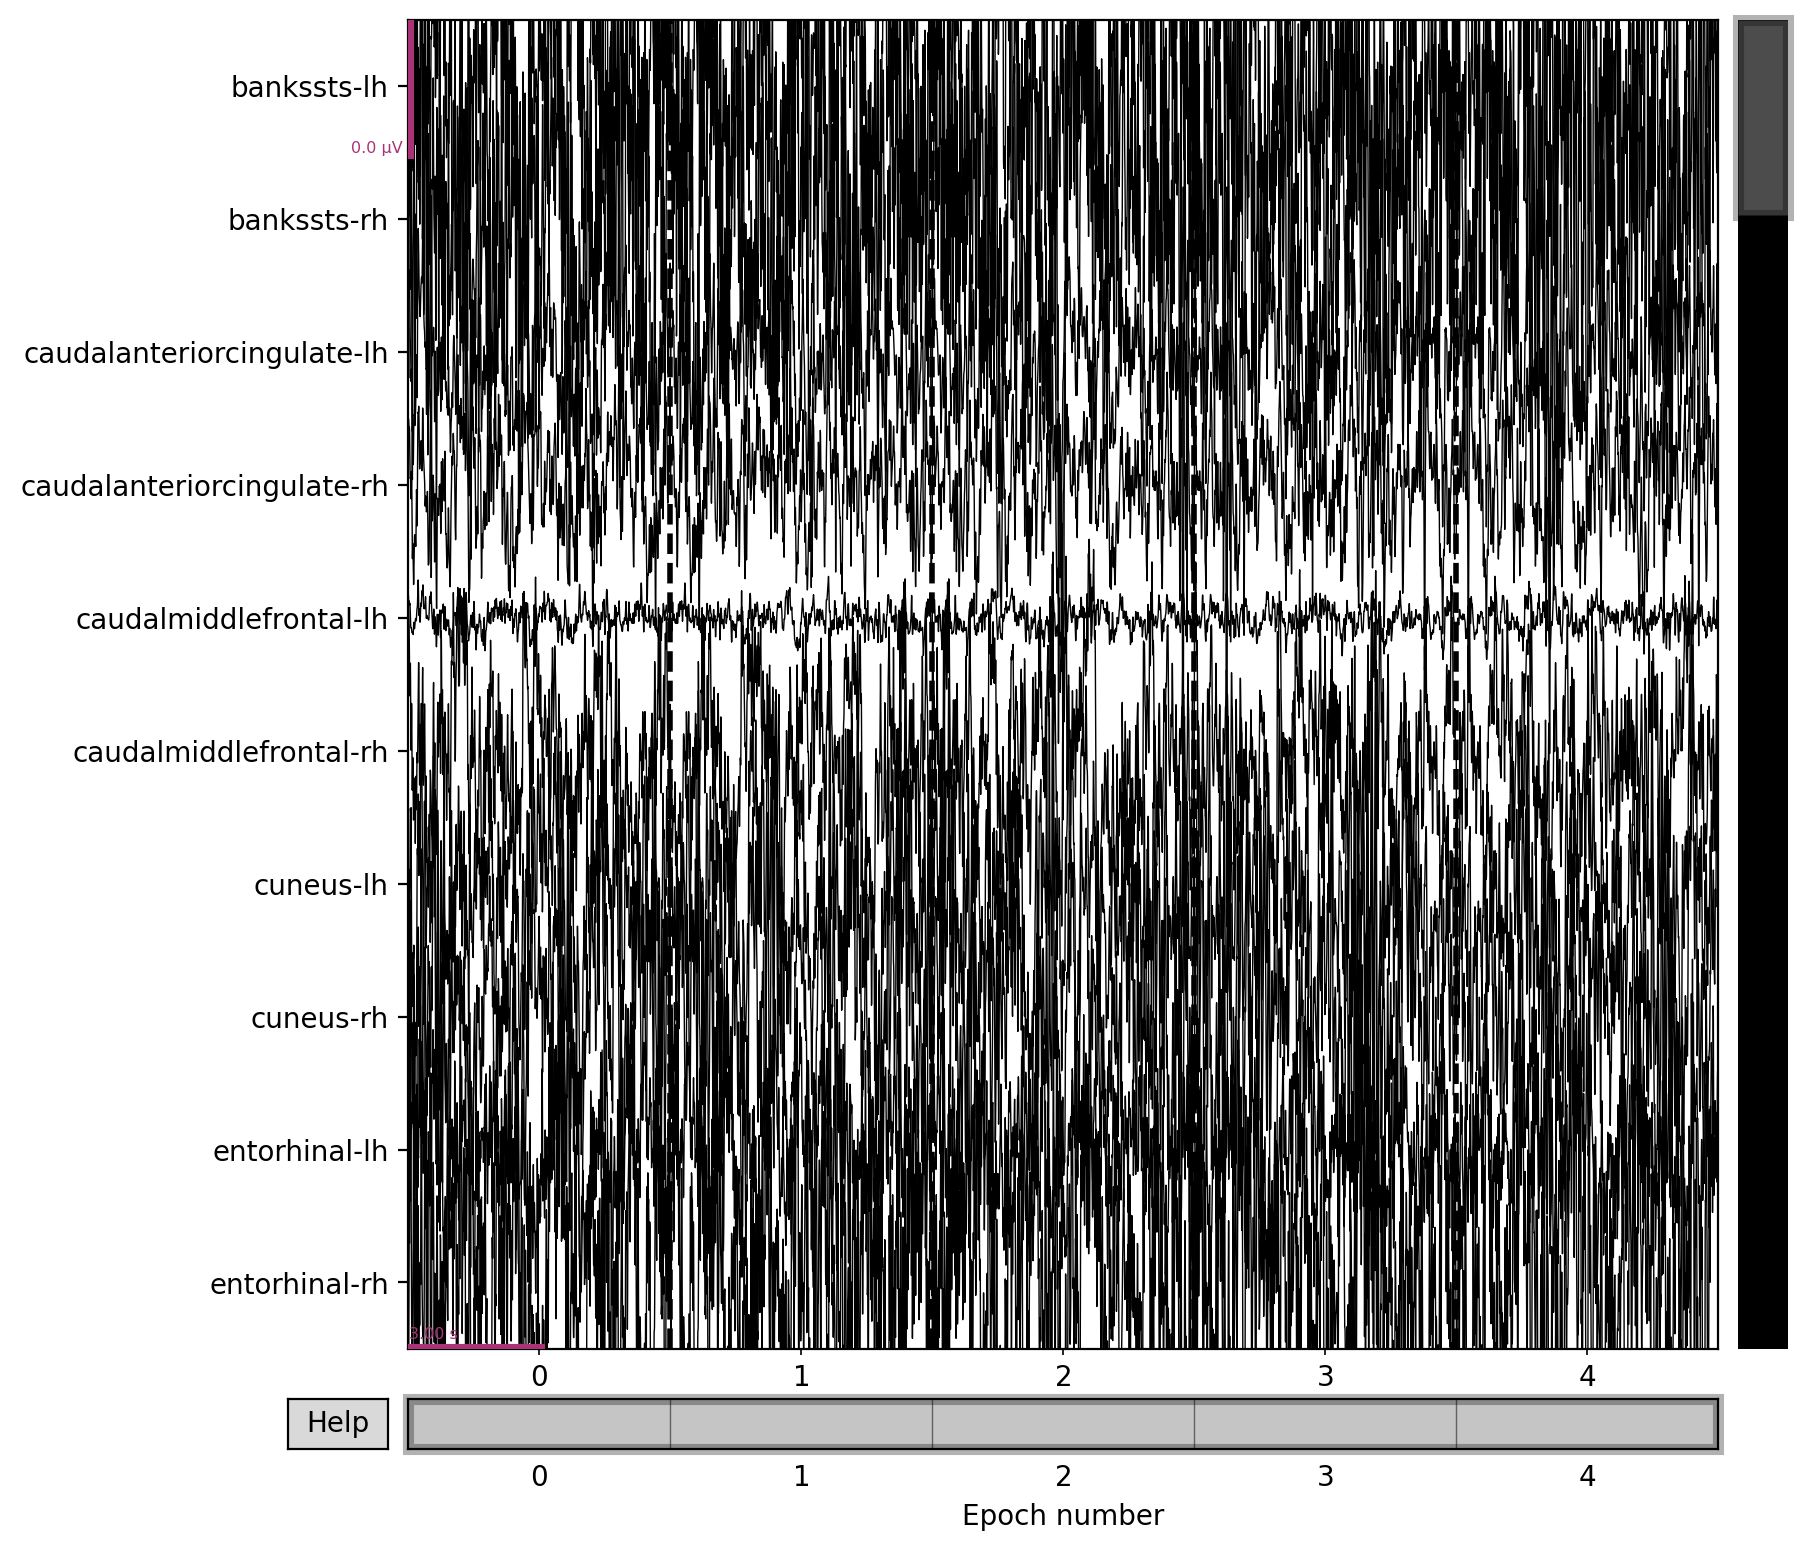

Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [ ]:
label_ts_reshaped = label_ts.reshape(n_labels, n_epochs, n_times).transpose(1, 0, 2)
print("New shape: ", label_ts_reshaped.shape)  # (n_epochs, n_labels, n_times)

# Create an EpochsArray object for ROI-based signals
info = mne.create_info(
    ch_names=[lbl.name for lbl in labels],
    sfreq=epochs.info['sfreq'],
    ch_types='eeg'
)
label_epochs = mne.EpochsArray(
    data=label_ts_reshaped,
    info=info,
    tmin=epochs.times[0],
    verbose=False
)

# Plot the ROI-level epochs
label_epochs.plot(n_channels=10, n_epochs=5, scalings="auto", title="ROI-level epochs")


# Conclusion

This notebook demonstrates a **memory-efficient** approach to EEG source 
reconstruction in MNE using a template subject (`fsaverage`). We:

1. Loaded epochs from EEGLAB format.
2. Set a 64-channel standard montage.
3. Computed (and saved) a forward solution.
4. **Looped label-by-label** to apply the inverse, reducing memory usage.
5. Extracted label time series and optionally reshaped them for epoch-style plotting.

From here, you could:
- Compute power spectra in each ROI,
- Investigate connectivity between ROIs,
- or visualize full-brain STCs for single epochs if you want 3D interactive plots 
  (by not restricting to `label=...` in `apply_inverse_raw`).

Happy analyzing!
